In [1]:
##before continuing the following packages need to be runned
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
portfolio_data <- read_csv("final_data.csv")|>
mutate(max_portfolio_return_name = as_factor(max_portfolio_return_name))|>
select(-year, -max_portfolio_return_value)
portfolio_data

Rows: 25 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): max_portfolio_return_name
dbl (5): year, annual_inflation, real_gdp_growth_rate_percentage, annual_une...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


annual_inflation,real_gdp_growth_rate_percentage,annual_unemployment_rate,max_portfolio_return_name
<dbl>,<dbl>,<dbl>,<fct>
2.337690,4.4,4.950000,60/40_portfolio_return_percentage
1.552279,4.5,4.508333,growth_portfolio_return_percentage
2.188027,4.8,4.216667,growth_portfolio_return_percentage
⋮,⋮,⋮,⋮
1.812210,2.3,3.666667,growth_portfolio_return_percentage
1.233584,-3.4,8.091666,growth_portfolio_return_percentage
4.697859,5.7,5.366667,growth_portfolio_return_percentage


In [3]:
#exloring our data:

num_obs <- nrow(portfolio_data)

portfolio_data |>
group_by(max_portfolio_return_name) |>
summarize(count = n(), percentage = n() / num_obs * 100)

#Word of caution: data seems to have too much "growth_portfolio" labels. Thus, rebalancing could be attempted: 

max_portfolio_return_name,count,percentage
<fct>,<int>,<dbl>
60/40_portfolio_return_percentage,3,12
growth_portfolio_return_percentage,15,60
income_portfolio_return_percentage,5,20
40/60_portfolio_return_percentage,2,8


In [4]:
#performing rebalancing:
install.packages("themis")
library (themis)

ups_recipe <- recipe(max_portfolio_return_name ~ ., data = portfolio_data) |>
step_upsample(max_portfolio_return_name, over_ratio = 1, skip = FALSE) |>
prep()
ups_recipe

upsampled_portfolio <- bake(ups_recipe, portfolio_data)

upsampled_portfolio |>
group_by(max_portfolio_return_name) |>
summarize(n = n())

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Training data contained 25 data points and no missing data.

Operations:

Up-sampling based on max_portfolio_return_name [trained]

max_portfolio_return_name,n
<fct>,<int>
60/40_portfolio_return_percentage,15
growth_portfolio_return_percentage,15
income_portfolio_return_percentage,15
40/60_portfolio_return_percentage,15


In [5]:
#comparing upsampled vs normal data:

print(upsampled_portfolio)
print (portfolio_data)

# A tibble: 60 × 4
   annual_inflation real_gdp_growth_rate_perc… annual_unemploy… max_portfolio_r…
              <dbl>                      <dbl>            <dbl> <fct>           
 1             1.62                        2.3             6.17 60/40_portfolio…
 2             2.34                        4.4             4.95 60/40_portfolio…
 3             1.26                        1.7             4.87 60/40_portfolio…
 4             1.26                        1.7             4.87 60/40_portfolio…
 5             2.34                        4.4             4.95 60/40_portfolio…
 6             2.34                        4.4             4.95 60/40_portfolio…
 7             1.62                        2.3             6.17 60/40_portfolio…
 8             1.62                        2.3             6.17 60/40_portfolio…
 9             1.62                        2.3             6.17 60/40_portfolio…
10             2.34                        4.4             4.95 60/40_portfolio…
# … with 

As seen above, upsampling would harm our data as it would create fictitious data points just for the sake of balancing out the labels. This in turn, would harm our real-life prediction accuracy interpretation since the data point created don't make any real sense.Therefore, for the rest of the classification, we won't be using upsampled data.

In [6]:
set.seed(9999) #ensuring reproducibility
options(repr.plot.height = 5, repr.plot.width = 6)

#splitting with normal data:
portfolio_split <- initial_split(portfolio_data, prop = 0.75, strata = max_portfolio_return_name)
portfolio_train <- training(portfolio_split)
portfolio_test <- testing(portfolio_split) 


#exploring distribution of labels in each split:

portfolio_train |>
group_by(max_portfolio_return_name) |>
summarize(count = n(), percentage = n() / num_obs * 100)

portfolio_test |>
group_by(max_portfolio_return_name) |>
summarize(count = n(), percentage = n() / num_obs * 100)

max_portfolio_return_name,count,percentage
<fct>,<int>,<dbl>
60/40_portfolio_return_percentage,2,8
growth_portfolio_return_percentage,11,44
income_portfolio_return_percentage,3,12
40/60_portfolio_return_percentage,2,8


max_portfolio_return_name,count,percentage
<fct>,<int>,<dbl>
60/40_portfolio_return_percentage,1,4
growth_portfolio_return_percentage,4,16
income_portfolio_return_percentage,2,8


The distribution of both split and test indicate that most of the data labels are "growth_portfolio". Hence this is something to bare and be critical when interptreting our predictions below. The best way to avoid this is to ideally collect data of more years since, as mentioned above, upsampling would harm the real-life applicability of the model. 

In [7]:
#recipe with normal data:
knn_recipe <- recipe(max_portfolio_return_name ~ annual_inflation + real_gdp_growth_rate_percentage + annual_unemployment_rate, data = portfolio_train) |>
    step_center(all_predictors()) |>
    step_scale (all_predictors())

In [8]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
set_engine("kknn") |>
set_mode("classification") 

! Fold1: preprocessor 1/1, model 1/1: 12 samples were requested but there were 12 rows in the data. 7 will be ...

! Fold2: preprocessor 1/1, model 1/1: 12 samples were requested but there were 13 rows in the data. 8 will be ...

! Fold3: preprocessor 1/1, model 1/1: 12 samples were requested but there were 15 rows in the data. 10 will be...

! Fold3: internal:
  No observations were detected in `truth` for level(s): '60/40_portfoli...
  Computation will proceed by ignoring those levels.

! Fold4: preprocessor 1/1, model 1/1: 12 samples were requested but there were 16 rows in the data. 11 will be...

! Fold4: internal:
  No observations were detected in `truth` for level(s): '60/40_portfoli...
  Computation will proceed by ignoring those levels.

! Fold5: preprocessor 1/1, model 1/1: 12 samples were requested but there were 16 rows in the data. 11 will be...

! Fold5: internal:
  No observations were detected in `truth` for level(s): '60/40_portfoli...
  Computation will proceed by ig

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,multiclass,0.7133333,5,0.1245436,Preprocessor1_Model03
4,accuracy,multiclass,0.7133333,5,0.1245436,Preprocessor1_Model04
5,accuracy,multiclass,0.7133333,5,0.1245436,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,accuracy,multiclass,0.7133333,5,0.1245436,Preprocessor1_Model12
1,accuracy,multiclass,0.6133333,5,0.1057250,Preprocessor1_Model01
2,accuracy,multiclass,0.6133333,5,0.1057250,Preprocessor1_Model02


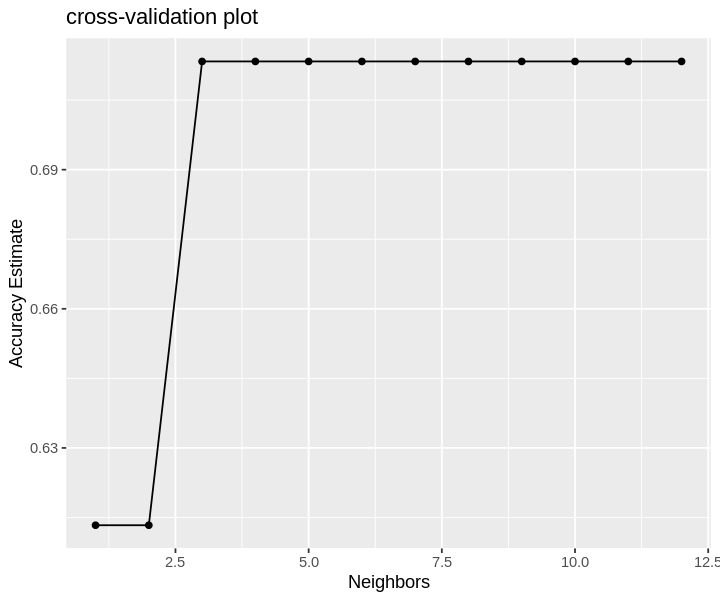

In [19]:
set.seed(9999) #ensuring reproducibility

knn_vfold <- vfold_cv(portfolio_train, v = 5, strata = max_portfolio_return_name)
gridvals <- tibble(neighbors = seq(from = 1, to = 12))

knn_results <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_tune) |>
  tune_grid(resamples = knn_vfold, grid = gridvals) |>
  collect_metrics() 

accuracies <- knn_results |> 
       filter(.metric == "accuracy") |>
       arrange(desc(mean))
accuracies


cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("cross-validation plot")
cross_val_plot

In [63]:
# based on the plot,  we will pick K=5 because of its high accuracy.
#Choosing k=5 ensures that going a bit to the righ or left leaves the accuracy estimate intact.
# We certainly believe that in order to enhance our model, more data should be collected for each variable. 
# Unfortunatly, our data was restricted for data from 1997-2021.

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
set_engine("kknn") |>
set_mode("classification")

knn_fit <- workflow() |>
add_recipe(knn_recipe) |>
add_model(knn_spec) |>
fit(data = portfolio_train)

In [64]:
#testing model predictions with testing set

set.seed(9999) #ensuring reproducibility

test_predictions <- predict(knn_fit,portfolio_test) |>
bind_cols(portfolio_test)

knn_metrics <- test_predictions |>
metrics(truth = max_portfolio_return_name, estimate = .pred_class)
knn_metrics
#accuracy seems to improve a bit (from 70% up to ~71%) when applying model to testing dataset

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7142857
kap,multiclass,0.4400000


In [75]:
#This is the new observation to predict

new_economic_environment_1 <- tibble(annual_inflation = 6, real_gdp_growth_rate_percentage = 2.5, annual_unemployment_rate = 3.7)
new_economic_environment_2 <- tibble(annual_inflation = 2, real_gdp_growth_rate_percentage = -1.6, annual_unemployment_rate = 7)

portfolio_prediction_1 <- predict(knn_fit, new_economic_environment_1)
portfolio_prediction_1

portfolio_prediction_2 <- predict(knn_fit, new_economic_environment_2)
portfolio_prediction_2

.pred_class
<fct>
growth_portfolio_return_percentage


.pred_class
<fct>
income_portfolio_return_percentage


# Interprating Model Predictions

Based on an economic environment with an expected annual US inflation, real GDP, and unemployment rate of 6%, 2.5%, and 3.7% respecively, our model peridicts that the top performing portfolio (out of the six we incorporated in our model) will be the growth portfolio. On the other hand, we we change our predictions to expected annual US inflation, real GDP, and unemployment rate of 2%, -1.6%, and 7% respecively, the income portfolio is suggested. The model is very interesting and could have the potential of providing real-world professional investment advice. Nontheless, the model lacks a lot of data and accuracy to be a serious contender. As previously mentioned, data going back to 1997 is not enough as to have a robust model. Furthermore, an accuracy of 70% is far from ideal. Lastely, the class used to in our model is limited by the amount of portfolio types. Thus, this model intrinsically ignore a whole other universe of investment porfolios and financial instruments ( i.e., not just mutual funds). 

Nontheless, we believe and are hopeful that a model with similar dynamics could be built by professionals with more time and resourced on their side.